In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

import warnings
warnings.filterwarnings("ignore")

sns.set_style()

In [2]:
dados = pd.read_csv(r'D:\Blue EdTech\Bootcamp\dados\full_grouped.csv')

In [3]:
paises = ['Mexico', 'Argentina', 'Ecuador', 'Chile', 'Spain']
df = dados[dados['Country/Region'].isin(paises)]
df['Date'] = pd.to_datetime(df.Date, format="%Y-%m-%d")

## SARIMAX

##### Diferença entre os novos casos por dia

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: >)

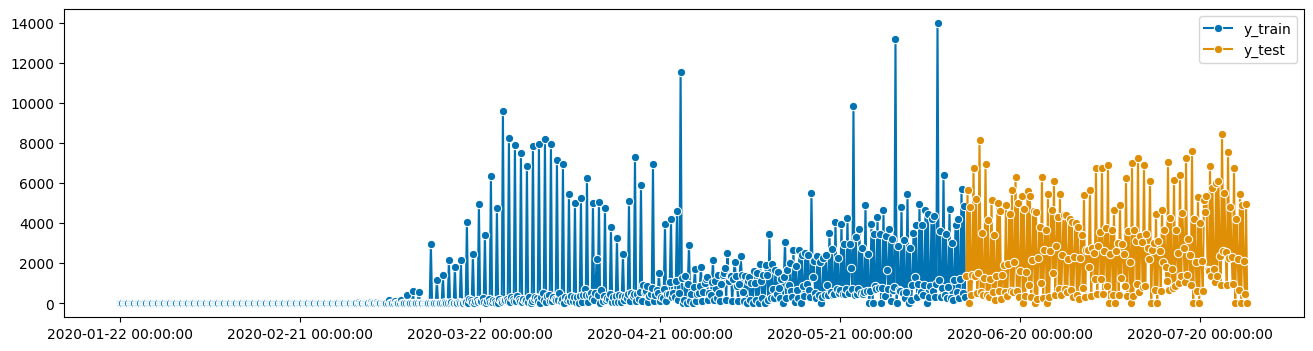

In [4]:
y = pd.Series(df['New cases'].values, df['Date'].values)
y_train, y_test = temporal_train_test_split(y)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

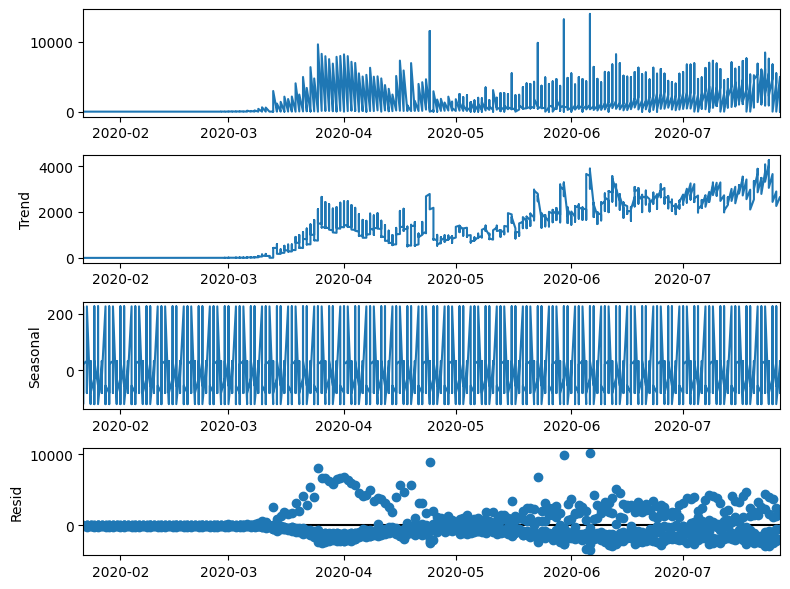

In [5]:
# decompor por semana
result = seasonal_decompose(y, model='additive', period=7)

fig = result.plot()
fig.set_size_inches((8, 6))

fig.tight_layout()
plt.show()

Foi utilizado a função seasonal_decompose da biblioteca stats models para dividir a série em três elementos: Tendência (trend), sazonalidade (seasonal) e resíduo (resid)

##### Aplicando a tecnica de SARIMAX na coluna 'New cases'

In [6]:
#!pip install pmdarima

In [7]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
novos_casos = df[['Date','New cases']].copy()

In [9]:
%%time

# criando o modelo
auto_arima(novos_casos['New cases'],seasonal=True,m=7).summary()

# ajustando o modelo
# colocamos os parametros start_p e start_q em 0 para
# serem os valores iniciais de treino e colocamos os 
# parametros max_p e max_q nos valores finais. 
# m=7 que será de observacoes diária
stepwise_fit = auto_arima(novos_casos['New cases'], start_p=0, start_q=0, 
    max_p=6, max_q=3, m=7,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=17519.376, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17696.018, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17164.382, Time=0.30 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17694.018, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17170.874, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17084.491, Time=0.69 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=16930.207, Time=1.81 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17068.265, Time=0.33 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=16740.685, Time=1.99 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=16932.776, Time=2.05 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=16661.226, Time=2.99 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=17297.347, Time=1.94 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=17025.094, Time=2.04 sec
 ARIMA(0,1,1)(2,0,2)[7] i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  940
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -7812.491
Date:                                Wed, 14 Dec 2022   AIC                          15648.981
Time:                                        14:47:52   BIC                          15707.119
Sample:                                             0   HQIC                         15671.145
                                                - 940                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0658      0.067     -0.978      0.328      -0.198       0.066
ar.L2         -0.2108      0.036     -5.889      0.000      -0.281      -0.141
ar.L3         -0.1325      0.048     -2.785      0.005      -0.226      -0.039
ar.L4         -0.1369      0.054     -2.536      0.011      -0.243      -0.031
ar.L5          0.5595      0.039     14.221      0.000       0.482       0.637
ar.L6         -0.0750      0.061     -1.221      0.222      -0.195       0.045
ma.L1         -0.9501      0.022    -44.086      0.000      -0.992      -0.908
ar.S.L7        0.6284      0.032     19.671      0.000       0.566       0.691
ar.S.L14      -0.9396      0.026    -36.649      0.000      -0.990      -0.889
ma.S.L7       -0.5477      0.054    -10.208      0.000      -0.653      -0.443
ma.S.L14       0.7981      0.049     16.450      0.000       0.703       0.893
sigma2       1.12e+06   2.35e+04     47.665      0.000    1.07e+06    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             54439.23
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               8.51   Skew:                             2.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
%%time

cut = int(novos_casos.shape[0] * 0.80)
train = novos_casos.iloc[:cut]
test = novos_casos.iloc[cut:]

# modelo
model = SARIMAX(train['New cases'],order=(6,1,1),seasonal_order=(2,0,[1,2],7))
model_fit = model.fit()
model_fit.summary()

CPU times: total: 5.89 s
Wall time: 7.68 s


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Wed, 14 Dec 2022   AIC                          12583.614
Time:                                        14:48:00   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0849      0.095     -0.898      0.369      -0.270       0.100
ar.L2         -0.2033      0.047     -4.306      0.000      -0.296      -0.111
ar.L3         -0.1543      0.047     -3.269      0.001      -0.247      -0.062
ar.L4         -0.1724      0.064     -2.704      0.007      -0.297      -0.047
ar.L5          0.5757      0.047     12.264      0.000       0.484       0.668
ar.L6         -0.1119      0.090     -1.236      0.216      -0.289       0.066
ma.L1         -0.9442      0.029    -33.082      0.000      -1.000      -0.888
ar.S.L7        0.3266      0.055      5.989      0.000       0.220       0.434
ar.S.L14      -0.8679      0.059    -14.602      0.000      -0.984      -0.751
ma.S.L7       -0.1783      0.054     -3.313      0.001      -0.284      -0.073
ma.S.L14       0.9087      0.050     18.074      0.000       0.810       1.007
sigma2      1.229e+06   3.54e+04     34.734      0.000    1.16e+06     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):             41168.61
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):            1554.76   Skew:                             3.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

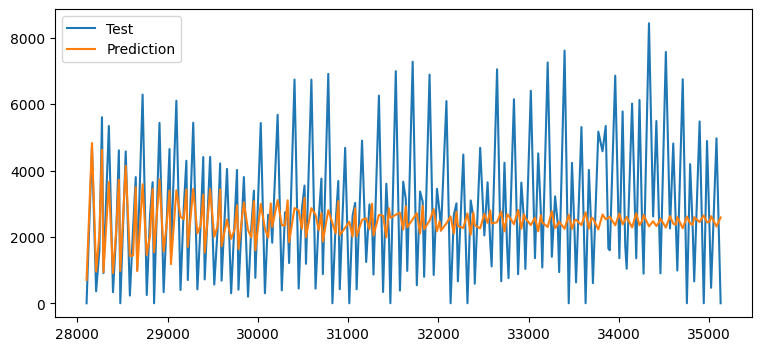

CPU times: total: 234 ms
Wall time: 369 ms


In [11]:
%%time

start = train.shape[0]
end   = novos_casos.shape[0] - 1

pred = model_fit.predict(start=start, end=end, dynamic=False, typ='levels')
pred.index = test.index

plt.figure(figsize=(14,10))
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

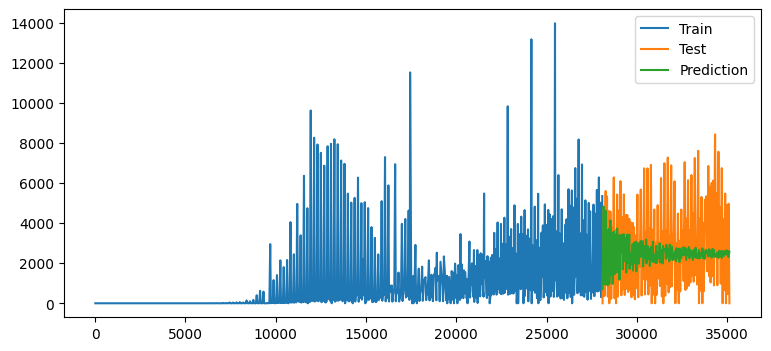

In [12]:
plt.figure(figsize=(14,10))
train['New cases'].plot(legend=True, label='Train')
test['New cases'].plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction', figsize=(9,4))
plt.show()

In [13]:
print(f"R²   ---  {r2_score(test['New cases'], pred):.2f}")
print(f"MAE  ---  {mean_absolute_error(test['New cases'], pred):.2f}")
print(f"RMSE ---  {mean_squared_error(test['New cases'], pred, squared=False):.2f}")
print(f"MAPE ---  {mean_absolute_percentage_error(test['New cases'], pred)}")


R²   ---  0.10
MAE  ---  1598.92
RMSE ---  2034.90
MAPE ---  7.005516650594642e+17


### Estacionariedade de Dickey Fuller

### Função para criar serie
* com confirmados e obitos
* a coluna de data como index

In [166]:
def criar_serie(df, nome_pais):

    filtro = df[df['Country/Region'] == nome_pais]
    pais = filtro[['Date', 'Confirmed', 'Deaths']]
    
    pd.to_datetime(pais.Date)
    pais.set_index('Date', inplace=True)
    
    return pais

In [167]:
argentina = criar_serie(df, 'Argentina')
chile = criar_serie(df, 'Chile')
equador = criar_serie(df, 'Ecuador')
mexico = criar_serie(df, 'Mexico')
espanha = criar_serie(df, 'Spain')

In [174]:
full_serie = criar_serie(df, df['Country/Region'])

### Media movel

In [262]:
def media_movel(serie, periodo):
    
    fig, axs = plt.subplots(2, 1, figsize=(15, 5), constrained_layout=True)

    # Valores originais
    ax = axs[0]
    mm = serie.Confirmed.resample(periodo).mean() # O periodo da media movel pode ser um numero inteiro seguido de D, W, M, Y ou apenas as iniciais
    ax.set_title(r'Valor original e média movel de Confirmados')
    ax.plot(serie.Confirmed, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')

    # Media movel
    ax = axs[1]
    mm = serie.Deaths.resample(periodo).mean()
    ax.set_title(r'Valor original e média movel de Obitos')
    ax.plot(serie.Deaths, color='blue', label='Original')
    ax.plot(mm, color='red', label='Média movel')
    ax.legend(loc='best')


    return plt.show

### Analise de tendencia

O '.resample(periodo).mean()' na função media_movel irá retornar a media movel, fazendo com que seja possivel observar o grafico da serie sem os ruidos, facilitando a analise de tendencia dos dados.

Para entender melhor como funciona a media movel, suposmos que será utilizado o periodo de 15 dias para o salto da janela de observação, os primeiro 14 dias serão pulados, e apenas o dia 15 será observado, apartir desse dia, a media do dia posterior será calculada baseada na media dos 15 dias anteriores e o processo será repetido até o fim da serie.

<function matplotlib.pyplot.show(close=None, block=None)>

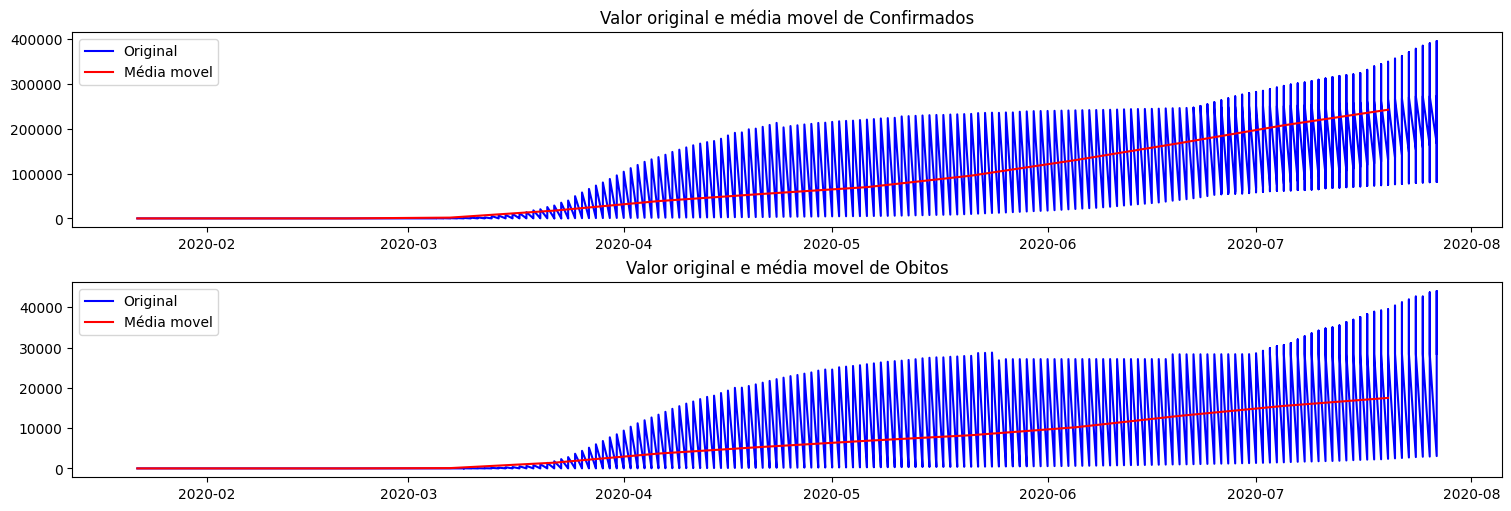

In [263]:
media_movel(full_serie, periodo='15D')

### Analise de sazionalidade

diff() ou diferença sucessiva, defini quantas diferenças será utilizado, por padrão o periodo é 1. (pesquisar sobre diferença sucessiva)

<AxesSubplot: xlabel='Date'>

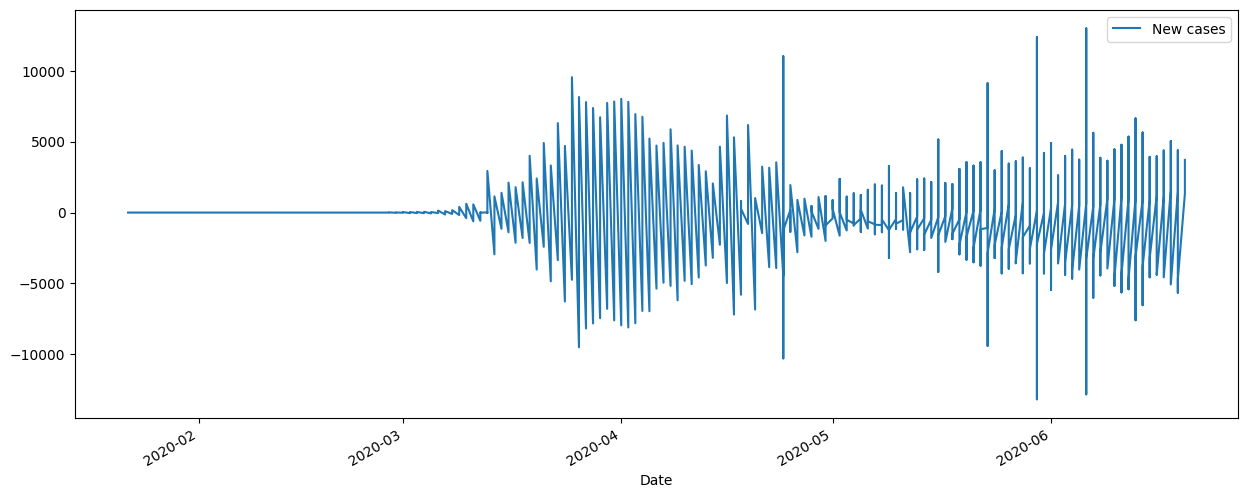

In [22]:
temp_test.diff().plot(figsize=(15,6)) 

In [23]:
# criando filtros para analiser melhor o grafico
filtro = (temp_test.index.month >= 3) & (temp_test.index.month <=6)

<AxesSubplot: xlabel='Date'>

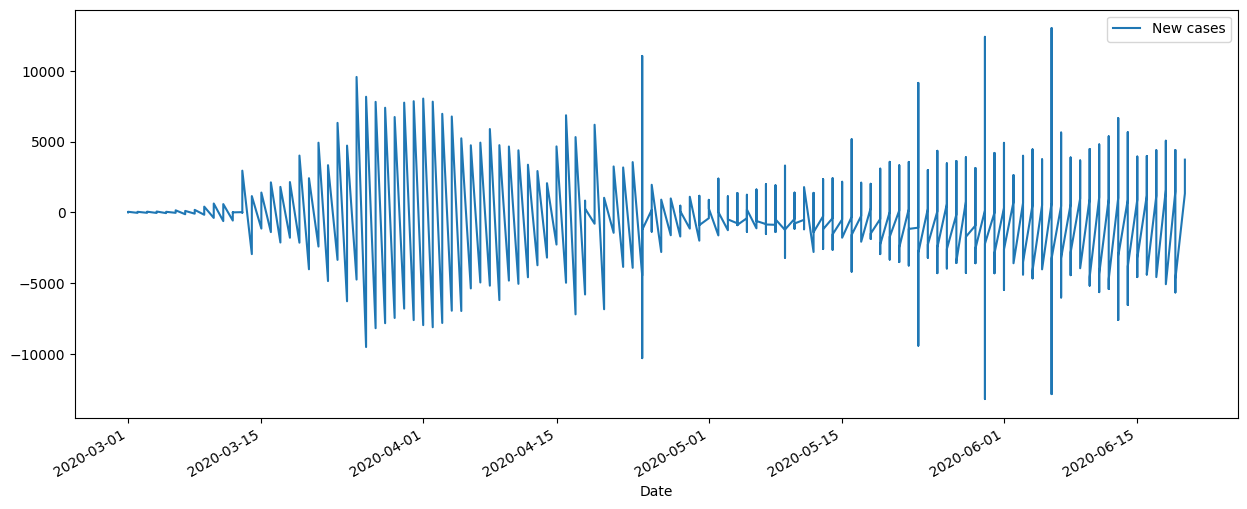

In [24]:
temp_test[filtro].diff().plot(figsize=(15,6))

Os picos se manifestam proximos ao inicio do mês e tbm parece aparecerem quinzenalmente.

In [28]:
from statsmodels.tsa.stattools import adfuller

ADF Statistic: -1.0604508327893594
p-value: 0.7305833336854521
                                       SARIMAX Results                                        
Dep. Variable:                              New cases   No. Observations:                  752
Model:             SARIMAX(6, 1, 1)x(2, 0, [1, 2], 7)   Log Likelihood               -6279.807
Date:                                Wed, 14 Dec 2022   AIC                          12583.614
Time:                                        14:48:13   BIC                          12639.071
Sample:                                             0   HQIC                         12604.981
                                                - 752                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.08

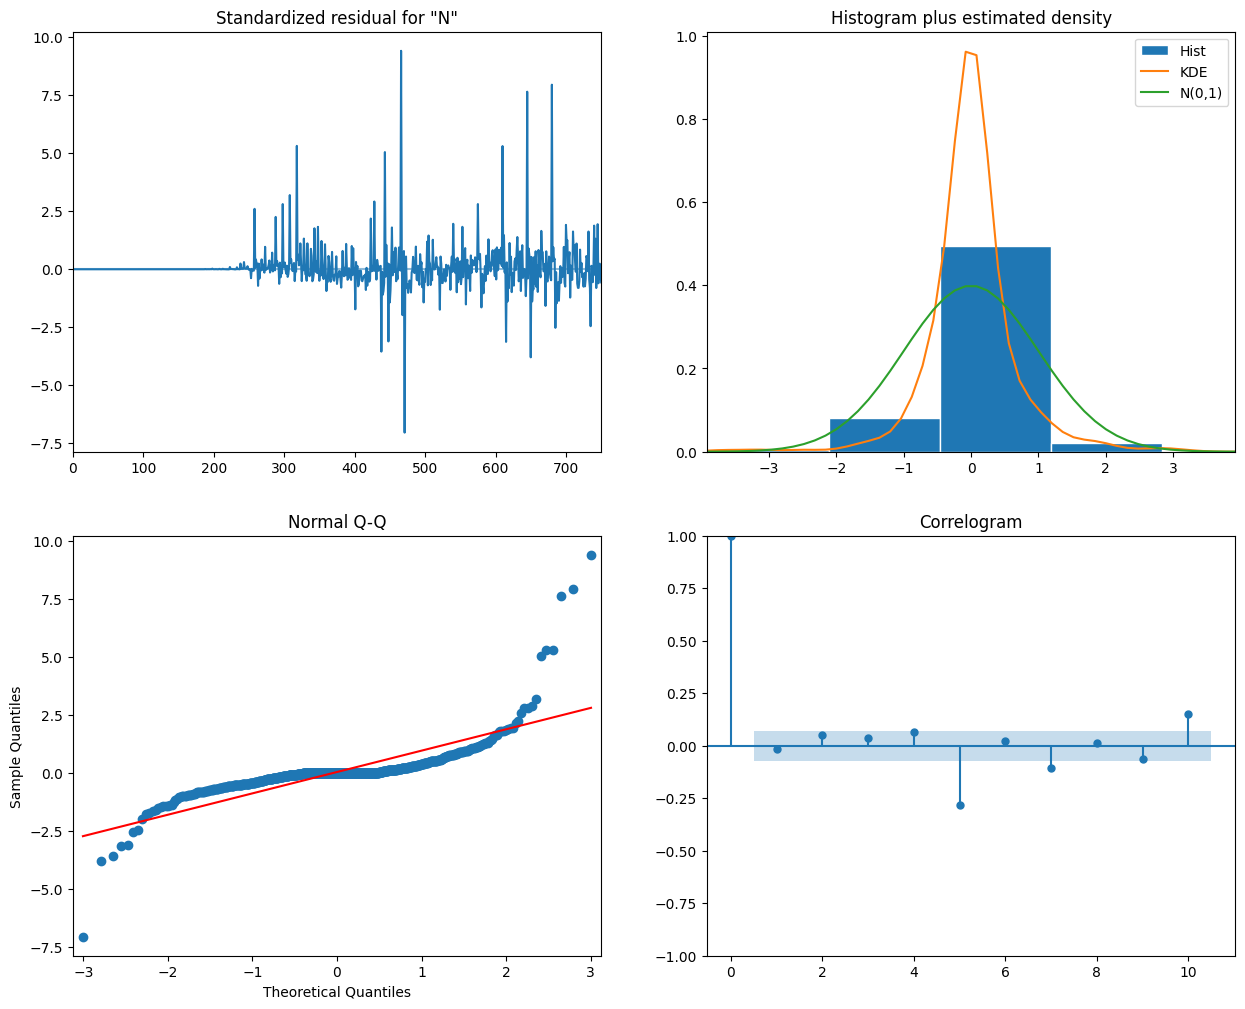

<Figure size 640x480 with 0 Axes>

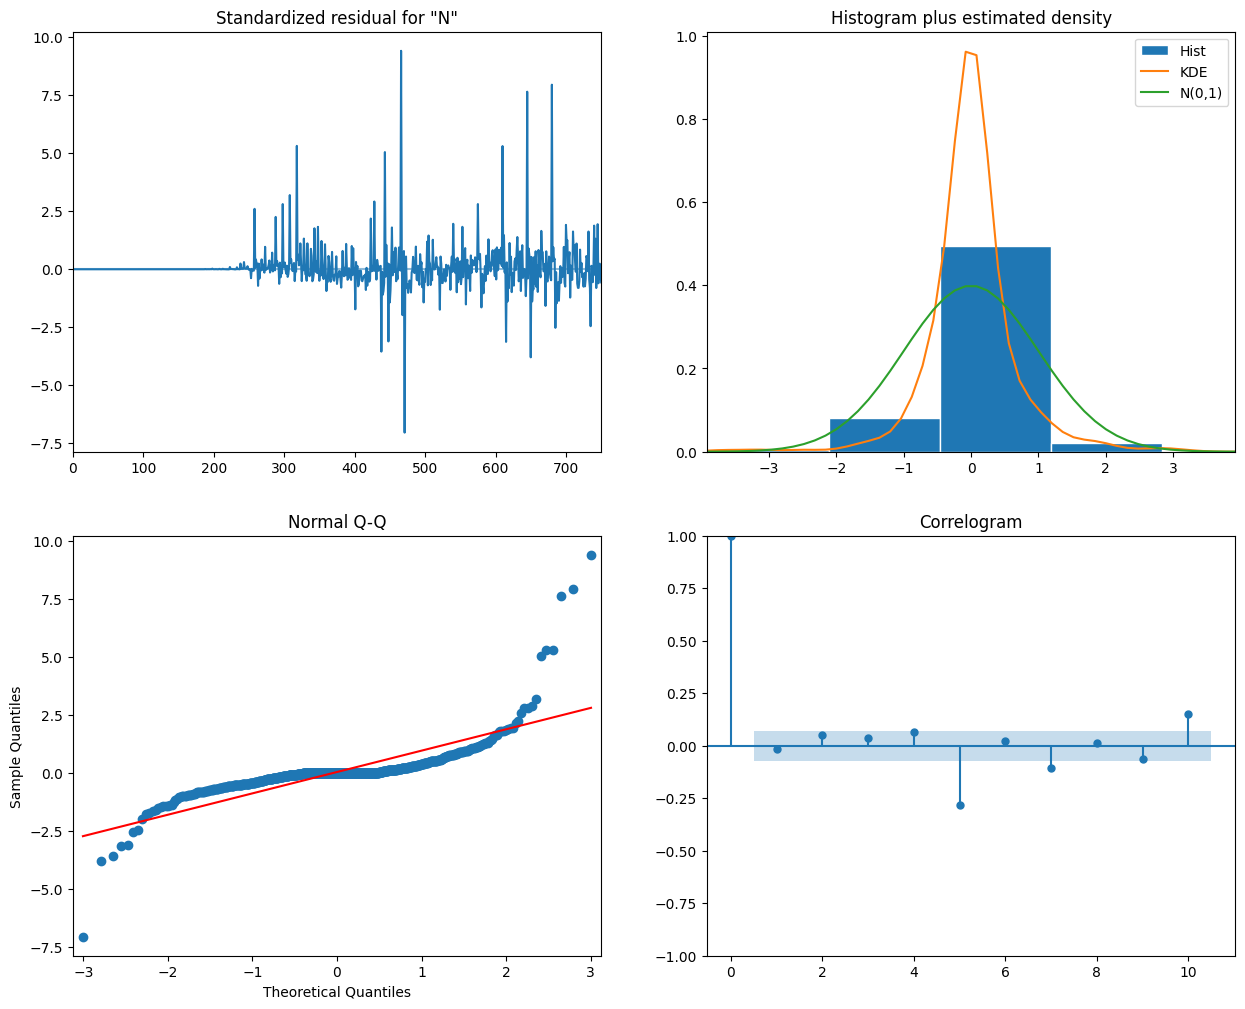

In [29]:
#x = organic_search.groupby('Week_Start_Date').Amount.sum()

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(temp_test)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# SARIMA Model
plt.figure(2)
#best_model = SARIMAX(test['New cases'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 52)).fit(dis=1)
best_model = SARIMAX(temp_test,order=(6,1,1),seasonal_order=(2,0,[1,2],7)).fit(dis=1)
#best_model = SARIMAX(test['New cases'], order=(2, 1, 1), seasonal_order=(2, 1, 1, 52)).fit(dis=1)
print(best_model.summary())
best_model.plot_diagnostics(figsize=(15,12))

## Modelo ThetaForecaster

In [30]:
#from xgboost import XGBRegressor

from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import MeanAsymmetricError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
#from sktime.performance_metrics.forecasting import smape_loss

In [31]:
%%time

y_train, y_test = temporal_train_test_split(y)
fh = np.arange(1, len(y_test) + 1)  
forecaster = ThetaForecaster(sp=12, deseasonalize=False)  
forecaster.fit(y_train.values)
y_pred = forecaster.predict(fh)
#smape_loss(y_test, y_pred) #0.08661469103230263
#MeanAbsolutePercentageError(y_test, y_pred)

CPU times: total: 31.2 ms
Wall time: 113 ms


Erro Médio Absoluto (MAE), que é a média dos erros absolutos (ignorando o sinal positivo ou negativo). Assim sabemos melhor quanto estamos desviando dos valores reais nas unidades originais.

Erro Percentual Absoluto Médio (MAPE). É uma métrica bastante utilizada na área de previsões de séries temporais, e se refere à média do percentual de erros cometidos nas previsões, desconsiderando a direção (acima ou abaixo do real).

In [32]:
print(f"R²   ---  {r2_score(y_test, y_pred):.2f}")
print(f"MAE  ---  {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE ---  {mean_squared_error(y_test, y_pred, squared=False):.2f}")
print(f"MAPE ---  {mean_absolute_percentage_error(y_test, y_pred)}")


R²   ---  -0.01
MAE  ---  1827.85
RMSE ---  2187.61
MAPE ---  6.731194031802877e+17
